# Community Housing survey Project (CHP) EDA
This notebook is designed to do exploratory data analysis (EDA) for the 2020 PhD-Community Initiative Housing
Survey dataset

Coded by Josh Moskowitz in February 2020

---




Import the relevant libraries and other setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Setup
%matplotlib inline
pd.set_option('display.max_columns', None)

Import survey data

In [2]:
#survey = pd.read_excel('F:/Users/Josh/Dropbox/PhD-CI/KCH_01312020.xlsx',index_col=None,header=0)
survey = pd.read_excel('C:/Users/Josh/Desktop/Dropbox/PhD-CI/KCH_01312020.xlsx',index_col=None,header=0)
questions = survey.iloc[0][:] # grab question wording and store for later

## Cleanup survey data

Remove unecessary rows and cols

In [3]:
survey.drop(index=[0,1],inplace=True) # remove first 2 rows
# Remove any irrelevant or personally idenitifying columns
survey.drop(labels=['Status','IPAddress','RecipientLastName','RecipientFirstName','RecipientEmail',
                    'ExternalReference','LocationLatitude','LocationLongitude','DistributionChannel',
                    'UserLanguage','info','consent'],axis=1,inplace=True)
survey.reset_index(drop=True, inplace=True) # reset index

Remove Whitespace and weird characters

In [4]:
def cleanDataFrame(obj):
    "Return a modified string"
    if isinstance(obj, str): # if object is a string
        return obj.replace("â€™", "'").strip() # fix apostrophes and remove trailing whitespace
    else:
        return obj

survey = survey.applymap(cleanDataFrame)

Function that will strip commas and split string when a person gave multiple responses

In [5]:
def cleanAndSplit(string):
    "Return a list of strings split by comma"
    
    # remove commas from one of the possible survey responses
    # "I need to be closer to work, childcare, or social/health support services"
    if "I need to be closer to work" in string:
        idx1 = string.find("childcare") - 2
        idx2 = string.find(" or ") - 1
        cleanString = string[:idx1] + string[idx1:idx2].replace(',','') + string[idx2+1:]
    else:
        cleanString = string

    return cleanString.split(',')

Function that will recode the employment column to only include one employment type

In [6]:
def recodeEmploy(row):
    "Return a Pandas row object with modified employment data"
    
    if isinstance(row.employment,str):
        listStatus = cleanAndSplit(row.employment)
        # we don't care if students are employed or not
        if 'Student' in listStatus:
            row.employment = 'Student'
        # we don't care if retirees are employed or not
        elif 'Retired' in listStatus:
            row.employment = 'Retired'
        else:
            row.employment = listStatus[0]
    return row
survey = survey.apply(recodeEmploy,axis='columns')

# Helper functions

In [7]:
def SepResp(col):
    "Return a Pandas series containing all strings present across this col"
    lst = []
    for i in col:
        if isinstance(i,str):
            lst.append(cleanAndSplit(i)) # Append responses to List

    lst = [item for sublist in lst for item in sublist] # flatten list
    return pd.Series(lst,index=None) # convert to series

This function will automatically generate basic plotting of response frequency or percentage for desired cols

In [8]:
def plotResp(col,questions,order=None,normalize=False):
    "Creates a horizontal bar graph showing responses for this col"
    if 'why_move' in col:
        col = SepResp(col)
    if "Selected Choice" in questions[col.name]:
        title = questions[col.name][0:-17] # remove this extra text
    else:
        title = questions[col.name]
    ax = col.value_counts(normalize=normalize).reindex(order).plot(kind='barh',title=title)
    if normalize:
        plt.draw()
        ax.set_xlabel('Percentage (%)')
        labels = ax.get_xticklabels() # Get locations and labels
        labels = [round(float(label.get_text())*100) for label in labels] # convert to int
        ax.set_xticklabels(labels)
    else:
        ax.set_xlabel('Count')

In [9]:
list(survey.columns) # check col names for plotting

['StartDate',
 'EndDate',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'RecordedDate',
 'ResponseId',
 'num_applied',
 'num_applied_explain',
 'num_applied_explain_2_TEXT',
 'num_applied_explain_3_TEXT',
 'private_housing',
 'current_living_arr',
 'current_living_arr_6_TEXT',
 'why_move',
 'why_move_7_TEXT',
 'subsidy',
 'employment',
 'income_stable',
 'utilities',
 'debt',
 'mental_health',
 'substance_use',
 'gender',
 'age',
 'fam_status',
 'fam_status_5_TEXT',
 'first_nation',
 'vis_minority',
 'can_residency',
 'can_residency_3_TEXT']

## Demographic Data

### Gender

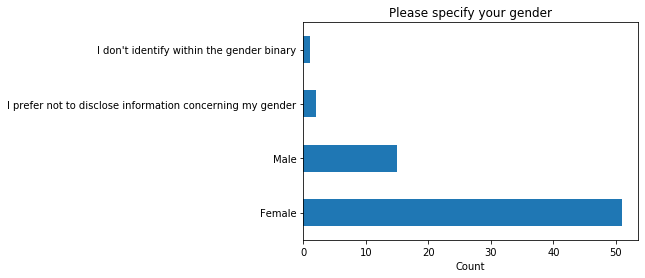

In [10]:
plotResp(survey['gender'],questions,normalize=False) # using helper function

### Age

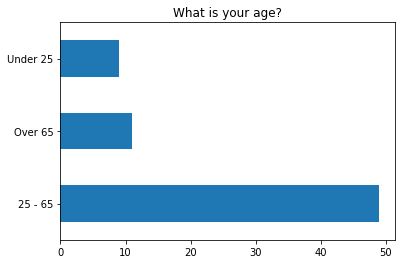

In [11]:
survey.age.value_counts().plot(kind='barh',title=questions['age'])

### Family Status

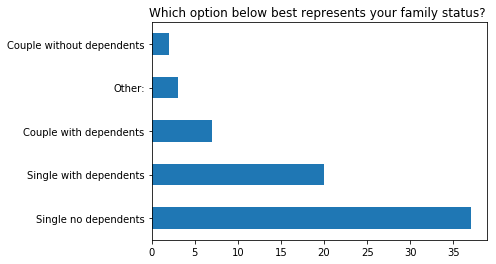

In [12]:
survey.fam_status.value_counts().plot(kind='barh',title=questions['fam_status'][0:-17])

### Do you identify as First Nation (Status/Non-Status), Métis, or Inuk (Inuit)?

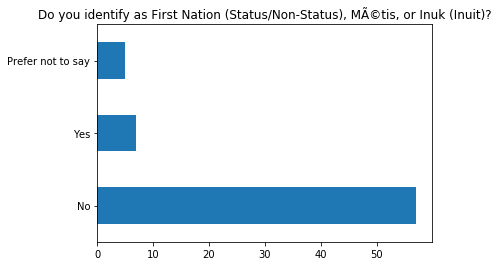

In [13]:
survey.first_nation.value_counts().plot(kind='barh',title=questions['first_nation'])

### Do you identify as a visible minority?

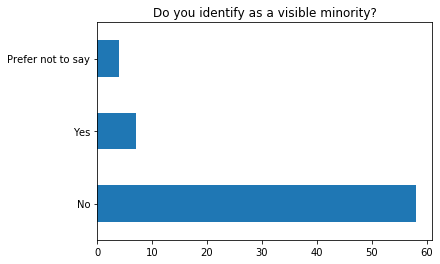

In [14]:
survey.vis_minority.value_counts().plot(kind='barh',title=questions['vis_minority'][0:-118])

### Residency Status

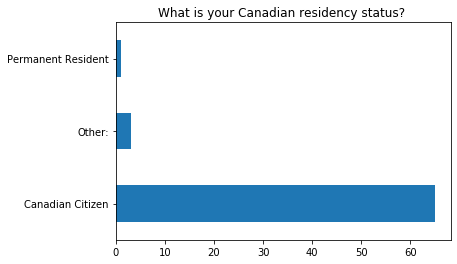

In [15]:
survey.can_residency.value_counts().plot(kind='barh',title=questions['can_residency'][0:-17])

### Employment Status

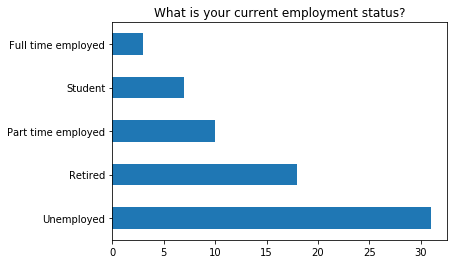

In [16]:
survey.employment.value_counts().plot(kind='barh',title=questions['employment'])

### Current Living Status

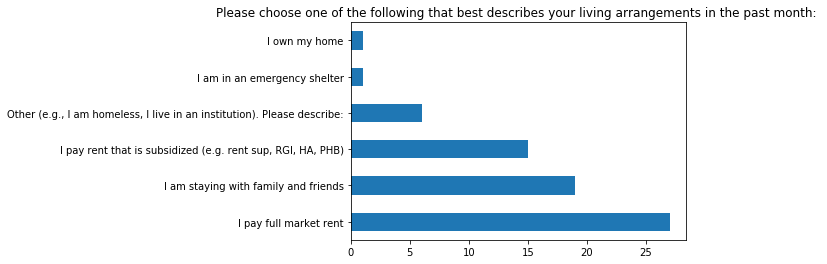

In [17]:
survey.current_living_arr.value_counts().plot(kind='barh',
    title=questions['current_living_arr'][0:-17])

### Reasons for moving

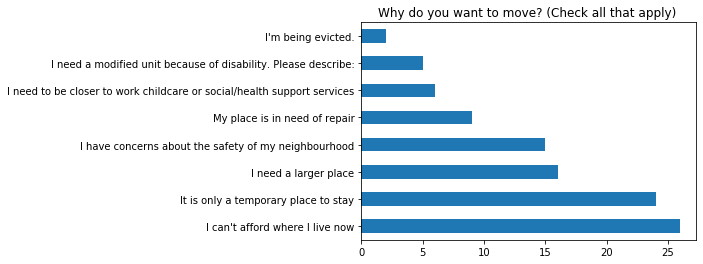

In [18]:
SepResp(survey.why_move).value_counts().plot(kind='barh',title=questions['why_move'][0:-17])

### Reason for moving broken down by current living status

In [147]:
# Col and Index names respectively for upcoming dataframe
livingNames = survey.current_living_arr.dropna().unique().tolist()
whyMoveNames = SepResp(survey.why_move).unique().tolist()

In [244]:
# Create dataframe and get a prop for each category
df_forStacked = pd.DataFrame(data=None,index=whyMoveNames,columns=None)
livingCounts = survey.current_living_arr.value_counts(normalize=True).reindex(livingNames)

Iterate through each row in our old dataframe, and apply a map operation to calculate new col values and concatenate to df

In [245]:
for col in livingNames: # for each living arr
    # generate a col to be added to the df
    rowItem = SepResp(survey.loc[survey.current_living_arr == col].why_move).value_counts(
    ).reindex(whyMoveNames).fillna(value=0)
    newRow = rowItem.map(lambda i: (i / rowItem.sum()) * livingCounts.loc[col]).to_frame() # convert to percentage of living arr
    newRow = newRow.rename(columns={0:col}) # rename col with actual to append to df
    df_forStacked = pd.concat([df_forStacked,newRow],axis=1)

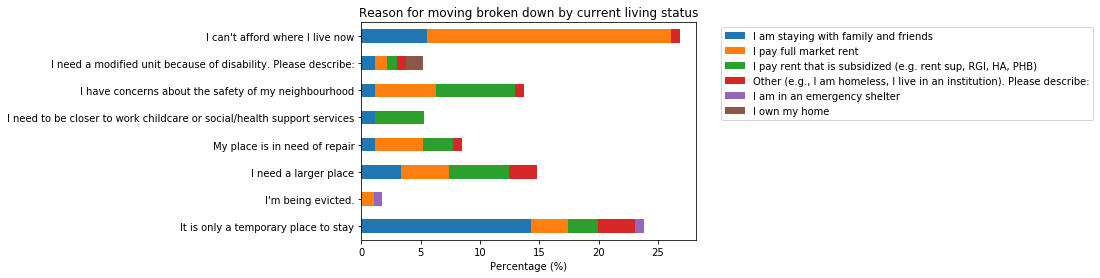

In [260]:
# Plotting
ax = df_forStacked.plot(kind='barh',stacked=True,title='Reason for moving broken down by current living status')
plt.draw()
ax.set_xlabel('Percentage (%)')
labels = ax.get_xticklabels() # Get locations and labels
labels = [round(float(label.get_text())*100) for label in labels] # convert to int
ax.set_xticklabels(labels);
ax.legend(loc='upper right', bbox_to_anchor=(2.2, 1))

## Waitlist Status

### Number of Times Applied for Waitlist status

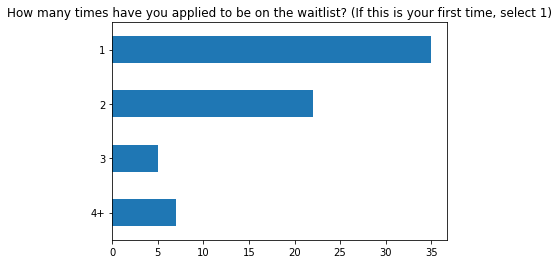

In [20]:
waitlistOrder = ['4+',3,2,1]
survey.num_applied.value_counts().loc[waitlistOrder].plot(
    kind='barh',title=questions['num_applied'])

### Reason for applying multiple times

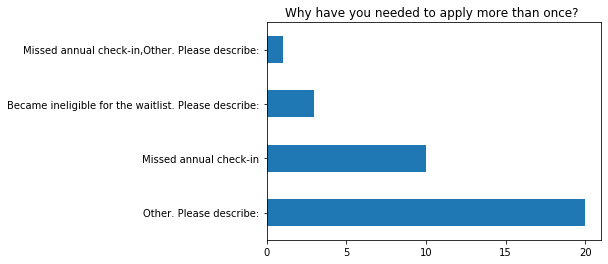

In [21]:
survey.num_applied_explain.value_counts().plot(kind='barh',xticks=np.arange(0, 25, step=5),
    title=questions['num_applied_explain'][0:-17])

### Applied to affordable housing options?

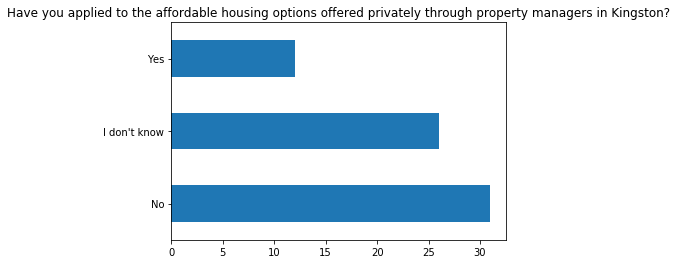

In [22]:
survey.private_housing.value_counts().plot(
    kind='barh',title=questions['private_housing'])

### Prefer to stay with rent subsidy

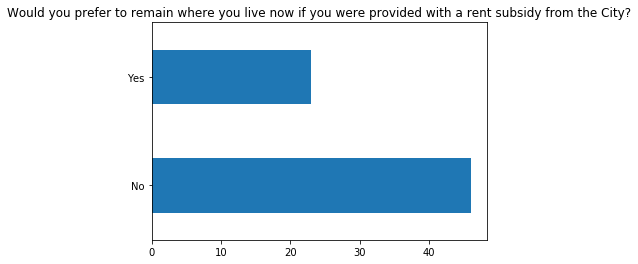

In [23]:
survey.subsidy.value_counts(sort=False).plot(kind='barh',title=questions['subsidy'])

### Why do people want/not want the rent subsidy?

In [24]:
# Group by subsidy, convert to dataframe, and rename data col
data = survey.groupby(['subsidy']).current_living_arr.value_counts(
).to_frame().rename(columns={'current_living_arr':'resp'})

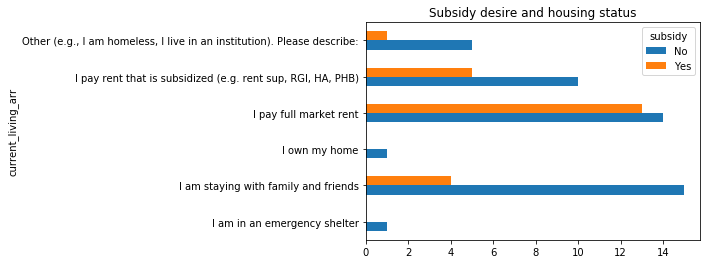

In [25]:
pd.pivot_table(data, index = 'current_living_arr', columns = 'subsidy', 
    values = 'resp').plot(kind = 'barh',title='Subsidy desire and housing status')

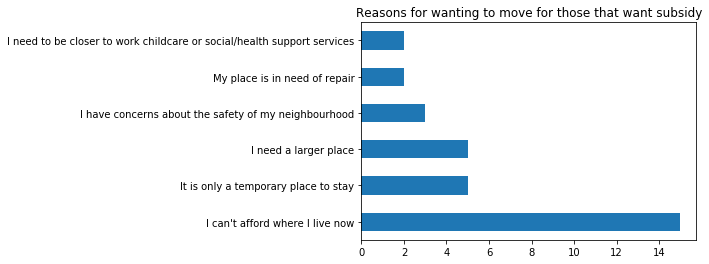

In [26]:
SepResp(survey.loc[(survey['subsidy']=='Yes')].why_move).value_counts().plot(
    kind='barh',title='Reasons for wanting to move for those that want subsidy')

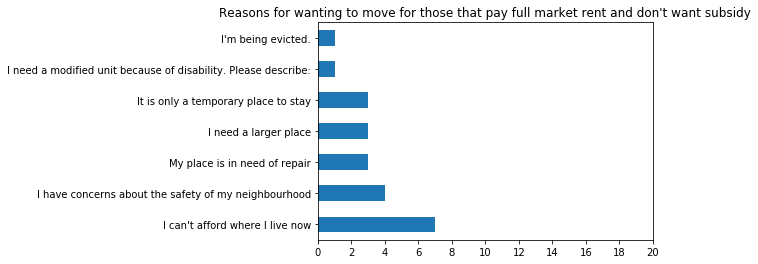

In [27]:
SepResp(survey.loc[(survey['subsidy']=='No') & 
    (survey['current_living_arr']=='I pay full market rent'
    )].why_move).value_counts().plot(kind='barh',
    title='Reasons for wanting to move for those that pay full market rent'
    ' and don\'t want subsidy',
    xticks=np.arange(0, 22, step=2))

### How stable is your income?

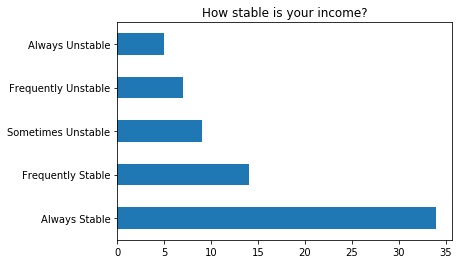

In [28]:
incomeOrder = ['Always Stable','Frequently Stable','Sometimes Unstable',
               'Frequently Unstable','Always Unstable']
survey.income_stable.value_counts().reindex(incomeOrder).plot(
                    kind='barh',title=questions['income_stable'])

### Do you struggle to pay your utilities bill?

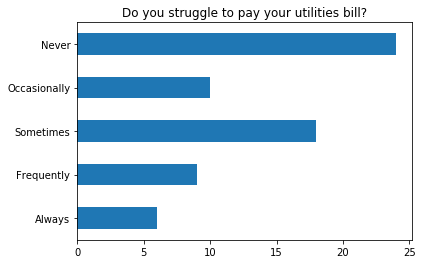

In [29]:
utilOrder = ['Always','Frequently','Sometimes','Occasionally','Never']
survey.utilities.value_counts().reindex(utilOrder).plot(
    kind='barh',title=questions['utilities'])

### Is debt a reason why you are seeking a new residence?

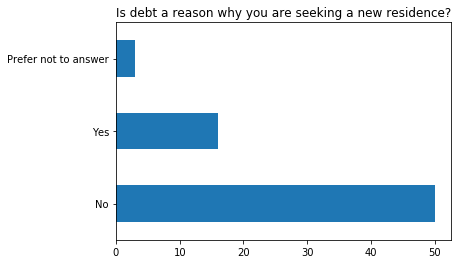

In [30]:
survey.debt.value_counts().plot(
    kind='barh',title=questions['debt'])

### How much do you struggle with mental health issues?

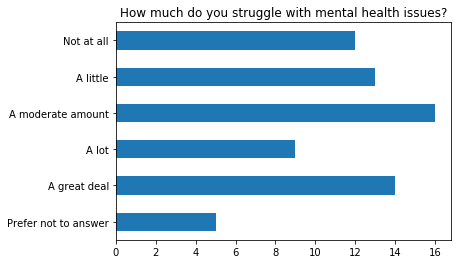

In [31]:
mentalOrder = ['Prefer not to answer','A great deal','A lot','A moderate amount',
              'A little','Not at all']
survey.mental_health.value_counts().reindex(mentalOrder).plot(
    kind='barh',title=questions['mental_health'])

### How much do you struggle with issues related to drinking or drug use?

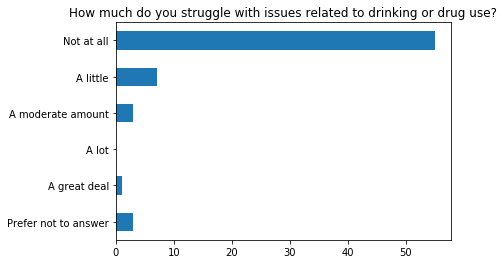

In [32]:
survey.substance_use.value_counts().reindex(mentalOrder).plot(
    kind='barh',title=questions['substance_use'])